In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rrank = lambda df,k: df[np.isclose(df['rrank'], 1/k)]
equal = lambda df,k: df[np.isclose(df['rrank'], 1/k)]
gequal = lambda df,k: df[np.isclose(df['rrank'], 1/k) | (df['rrank'].ge(1/k))]

def rrank_distribution(df, max_k):
    dist = pd.DataFrame(columns=['rank', 'count'])
    dist = dist.append({'rank': 0, 'count': df[np.isclose(df['rrank'], 0.000)].shape[0]}, ignore_index=True)
    for i in range(1, max_k):
        dist = dist.append({'rank': i, 'count': equal(df, i).shape[0]}, ignore_index=True)    
    return dist

In [4]:
al = pd.read_csv('/data/khodadaa/lucene-index/rranks.csv', header=None)
sub = pd.read_csv('/data/khodadaa/lucene-index/rr/05092047_sub2_rranks.csv', header=None)
al.rename(columns={0:'query', 1: 'prec@10', 2: 'prec@20', 3: 'rrank', 4: 'avg(prec)', 5: 'recall@200', 6: 'recall@1000', 7:'ndcg10'}, inplace=True)
sub.rename(columns={0:'query', 1: 'prec@10', 2: 'prec@20', 3: 'rrank', 4: 'avg(prec)', 5: 'recall@200', 6: 'recall@1000', 7:'ndcg10'}, inplace=True)

In [5]:
a1 = equal(al, 1)
s1 = equal(sub, 1)
a2 = gequal(al, 2)
s2 = gequal(sub, 2)
a3 = gequal(al, 3)
s3 = gequal(sub, 3)

In [6]:
query_assignment = pd.read_csv('/data/khodadaa/lucene-index/query-assignments/05092047_query_assignment.csv', header=None)
query_assignment.rename(columns={0: 'query', 1:'assignment'}, inplace=True)
query_assignment['assignment'] = query_assignment['assignment'].map(lambda x: x.strip())
query_assignment['query'] = query_assignment['query'].map(lambda x: x.strip())
query_assignment['rrank'] = -1.0
for index, row in query_assignment.iterrows():    
    if row['assignment'] == 'all':        
        rrv = al.loc[al['query']==row['query'], 'rrank']
    elif row['assignment'] == 'sub':        
        rrv = sub.loc[sub['query']==row['query'], 'rrank']
    if rrv.size == 0:
        continue
    query_assignment.loc[index, 'rrank'] = rrv.values[0]

In [7]:
tran1_sub = sub[sub['query'].isin(a1['query'])]
tran2_sub = sub[sub['query'].isin(a2['query'])]
tran3_sub = sub[sub['query'].isin(a3['query'])]
#query_assignment[query_assignment['rrank'] < 0.0]
tran1_alg = query_assignment[query_assignment['query'].isin(a1['query'])]
tran2_alg = query_assignment[query_assignment['query'].isin(a2['query'])]
tran3_alg = query_assignment[query_assignment['query'].isin(a3['query'])]

In [8]:
print(a1.shape[0], a2.shape[0], a3.shape[0])
print(s1.shape[0], s2.shape[0], s3.shape[0])
print(a1['rrank'].mean(), a2['rrank'].mean(), a3['rrank'].mean())
print(tran1_sub['rrank'].mean(), tran2_sub['rrank'].mean(), tran3_sub['rrank'].mean())
print(tran1_alg['rrank'].mean(), tran2_alg['rrank'].mean(), tran3_alg['rrank'].mean())

972 1657 2134
4147 4677 4924
1.0 0.7933011466505733 0.6904873477038426
0.8401577503429355 0.8500301750150875 0.8577527170785445
0.9008573388203017 0.8618990142828405 0.8469748351666421


In [9]:
from scipy.stats import ttest_rel
def t_test(data1, data2, alpha=0.05):
    # compare samples
    stat, p = ttest_rel(data1, data2)
    print('Statistics=%.3f, p=%.5f' % (stat, p))
    # interpret    
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
t_test(a1['rrank'], tran1_sub['rrank'])
t_test(a1['rrank'], tran1_alg['rrank'])
t_test(a2['rrank'], tran2_sub['rrank'])
t_test(a2['rrank'], tran2_alg['rrank'])

Statistics=13.831, p=0.00000
Different distributions (reject H0)
Statistics=10.582, p=0.00000
Different distributions (reject H0)
Statistics=-5.347, p=0.00000
Different distributions (reject H0)
Statistics=-7.023, p=0.00000
Different distributions (reject H0)


In [10]:
print('Cache rranks distribution\n', sub.groupby('rrank')['query'].count())
print('--------------')
print('All rranks distribution\n', al.groupby('rrank')['query'].count())

Cache rranks distribution
 rrank
0.000000    1541
0.005000       1
0.005102       1
0.005128       1
0.005155       1
0.005208       1
0.005236       1
0.005263       2
0.005319       1
0.005464       2
0.005495       1
0.005587       1
0.005650       1
0.005682       1
0.005714       1
0.005747       1
0.005780       1
0.005848       3
0.005882       1
0.005952       1
0.006024       1
0.006098       1
0.006135       1
0.006250       1
0.006369       1
0.006410       1
0.006494       1
0.006757       1
0.006849       2
0.006897       1
            ... 
0.033333       6
0.034483       5
0.035714       7
0.037037       8
0.038462       9
0.040000       9
0.041667       4
0.043478       5
0.045455      12
0.047619      10
0.050000      10
0.052632       9
0.055556       7
0.058824      12
0.062500      16
0.066667      15
0.071429      12
0.076923      13
0.083333      23
0.090909      38
0.100000      32
0.111111      37
0.125000      33
0.142857      51
0.166667      62
0.200000      9

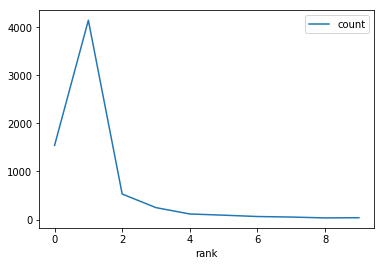

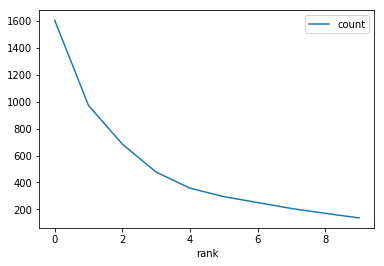

In [11]:
dist = rrank_distribution(sub, 10)
dist.plot(x='rank', y='count')
dist = rrank_distribution(al, 10)
dist.plot(x='rank', y='count')

# Stackoverflow

In [12]:
stack = pd.read_csv('/data/khodadaa/analysis/stack.csv').filter(items=['Query', 'TestViewCount', '18', '100', 'ql_t', 'ql_t.1'])
stack.rename(columns={'18': 'sub_rr', '100': 'all_rr', 'ql_t': 'sub_ql', 'ql_t.1': 'all_ql'}, inplace=True)

In [13]:
print('# Total queries:', stack.shape[0])
print('# Queries with no answer on sub:', stack[np.isclose(stack['sub_rr'], 0.0)].shape[0])
print('# Queries with no answer on all:', stack[np.isclose(stack['all_rr'], 0.0)].shape[0])

# Total queries: 1092107
# Queries with no answer on sub: 898617
# Queries with no answer on all: 29834


In [14]:
print('Sub rranks distribution\n', stack.groupby('sub_rr')['Query'].count())
print('--------------')
print('All rranks distribution\n', stack.groupby('all_rr')['Query'].count())

Sub rranks distribution
 sub_rr
0.00    898617
0.01      1384
0.02       923
0.03       828
0.04       737
0.05       742
0.06       874
0.07       944
0.08      1369
0.09       968
0.10      1349
0.11      1784
0.12      2503
0.14      3349
0.17      4913
0.20      6975
0.25     11202
0.33     18270
0.50     34636
1.00     99740
Name: Query, dtype: int64
--------------
All rranks distribution
 all_rr
0.00     29834
0.01     16776
0.02     19715
0.03     26904
0.04     26323
0.05     27749
0.06     29168
0.07     25291
0.08     31966
0.09     19408
0.10     21930
0.11     25023
0.12     29110
0.14     34063
0.17     40875
0.20     49690
0.25     62972
0.33     85030
0.50    132681
1.00    357599
Name: Query, dtype: int64


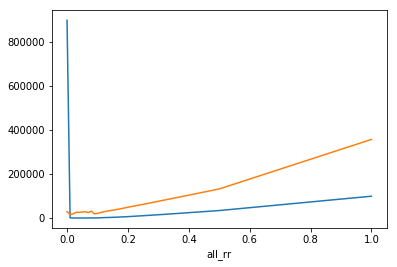

In [15]:
stack.groupby('sub_rr')['Query'].count().plot()
stack.groupby('all_rr')['Query'].count().plot()

In [16]:
stack2 = stack.copy()
for index, row in stack2.iterrows():
    if row['sub_ql'] >= row['all_ql']:
        stack2.loc[index, 'selected_rrank'] = row['sub_rr']
    else:
        stack2.loc[index, 'selected_rrank'] = row['all_rr']

In [17]:
print('# all queries:', stack2.shape[0])
print('Number of times query is submitted over the cache:', stack2[stack2['sub_ql']>stack2['all_ql']].count())

# all queries: 1092107
Number of times query is submitted over the cache: Query             557563
TestViewCount     557563
sub_rr            557563
all_rr            557563
sub_ql            557563
all_ql            557563
selected_rrank    557563
dtype: int64


In [30]:
as1 = stack2[stack2['all_rr'] == 1.0]
as2 = stack2[(stack2['all_rr'] == 1.0) | (stack2['all_rr'] ==0.5)]
print(stack2.shape[0], as1.shape[0], as2.shape[0])

1092107 357599 490280


In [19]:
print('rrank= 1.0\n',as1['all_rr'].mean(), as1['selected_rrank'].mean())
print('--------------------------------')
print('rrank= 1.0 or 0.5\n', as2['all_rr'].mean(), as2['selected_rrank'].mean())

rrank= 1.0
 1.0 0.6012430403888155
--------------------------------
rrank= 1.0 or 0.5
 0.864688545321041 0.5331181365750184


In [20]:
sub_nonzero = stack[~np.isclose(stack['sub_rr'], 0.0)]
all_nonzero = stack[~np.isclose(stack['all_rr'], 0.0)]
print(sub_nonzero[sub_nonzero['sub_rr'] < 0.01].shape[0])
print(all_nonzero[all_nonzero['all_rr'] < 0.01].shape[0])

0
0


# Tricks

<Figure size 432x288 with 0 Axes>

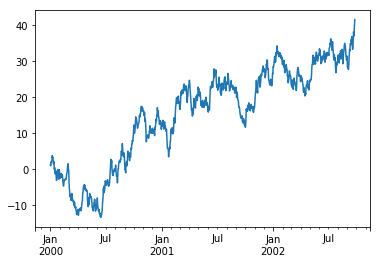

<Figure size 432x288 with 0 Axes>

In [21]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()
ts.plot()
plt.figure()

In [22]:
%%bash
find /data/khodadaa/analysis/ -name "*.csv"

/data/khodadaa/analysis/wiki13_counts13_cleaned.csv
/data/khodadaa/analysis/msn_query_qrel_merged.csv
/data/khodadaa/analysis/msn_left.csv
/data/khodadaa/analysis/msn_right.csv
/data/khodadaa/analysis/msn_inner.csv
/data/khodadaa/analysis/db_tfs.csv
/data/khodadaa/analysis/db_tfs_2.csv
/data/khodadaa/analysis/2013-adhoc.csv
/data/khodadaa/analysis/msn_answer_articles.csv
/data/khodadaa/analysis/2013-adhoc-inner.csv
/data/khodadaa/analysis/msn_clarity_2.csv
/data/khodadaa/analysis/msn_query_difficulties.csv
/data/khodadaa/analysis/2013-adhoc_query_difficulties.csv
/data/khodadaa/analysis/msn_corr_qd_pop.csv
/data/khodadaa/analysis/rranks_distribution_all.csv
/data/khodadaa/analysis/rranks_distribution_sub.csv
/data/khodadaa/analysis/stack.csv


In [23]:
%%latex
\begin{equation}
maximize \quad KLD(C,D) + \lambda \Sigma pop(d, C)\\
s.t. \quad \forall d \in C pop(d,C) \geq \theta_p
\end{equation}

<IPython.core.display.Latex object>